# Modélisation des autorisations de crédits

## Régression logistique

### Chargement des librairies

In [1]:
import sys
sys.path.insert(0, "/home/cyril/openclassrooms/projets/P7/P7_baudrillart_cyril_V2/custom_functions")

In [2]:
# Librairies Data Science
import pandas as pd
import numpy as np
from collections import Counter
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from model_analysis import plot_confusion_matrix, plot_roc_curve

In [3]:
# Scikit-Learn
from sklearn.model_selection import (cross_val_score,
                                     RepeatedStratifiedKFold,
                                     cross_validate,
                                     StratifiedKFold)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import (f1_score, recall_score,
                             roc_auc_score, precision_score,
                             r2_score, accuracy_score,
                             roc_curve, auc)
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

In [4]:
# Imbalanced-Learn
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

### Chargement des données

In [5]:
# Chargement des données intégrales imputées
X = pd.read_csv('../data_models/X_top10_imputed.csv', index_col=0)

In [6]:
X.shape  #taille du train set 

(292062, 12)

In [7]:
X.head()

,EXT_SOURCE_3,EXT_SOURCE_2,PREV_DAYS_DECISION_MIN,CODE_GENDER,DAYS_EMPLOYED,PREV_APP_CREDIT_PERC_MIN,INSTAL_DPD_MAX,AMT_CREDIT,DAYS_BIRTH,FLAG_OWN_CAR,NAME_EDUCATION_TYPE_Higher_education,TARGET
0,0.574447,0.092250,1229.0,1.0,335.0,0.627786,0.0,508495.5,20255.0,0.0,0.0,0.0
1,0.746300,0.779680,2688.0,1.0,5862.0,0.906651,0.0,728460.0,21989.0,0.0,0.0,0.0
2,0.159520,0.475448,1632.0,1.0,224.0,0.938086,0.0,239850.0,25054.0,0.0,0.0,0.0
3,0.456110,0.698863,2500.0,0.0,7093.0,0.000000,22.0,450000.0,18862.0,0.0,1.0,0.0
4,0.761026,0.658295,2608.0,1.0,224.0,0.000000,27.0,1350000.0,21817.0,1.0,0.0,0.0


In [8]:
X.isnull().sum()

EXT_SOURCE_3                            0
EXT_SOURCE_2                            0
PREV_DAYS_DECISION_MIN                  0
CODE_GENDER                             0
DAYS_EMPLOYED                           0
PREV_APP_CREDIT_PERC_MIN                0
INSTAL_DPD_MAX                          0
AMT_CREDIT                              0
DAYS_BIRTH                              0
FLAG_OWN_CAR                            0
NAME_EDUCATION_TYPE_Higher_education    0
TARGET                                  0
dtype: int64

In [9]:
# Comptage des classes
Counter(X['TARGET'])

Counter({0.0: 268139, 1.0: 23923})

La classe 1 (crédit non remboursé) est largement minoritaire

### Transformation des données d'entraînement

In [10]:
# Création de la target
y = X.TARGET
# Suppression la target des features
X = X.drop(columns='TARGET')

In [11]:
# création des train et test sets avec stratification (classes déséquilibrées)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)

# Tests régressions logistiques

## Régression logistique basique

Entrainement d'une regression logistique simple sans pénalisation ni rebalancing des classes.

In [13]:
# création d'un pipeline avec imblearn pipeline
pipeline1 = Pipeline([('scaler', MinMaxScaler()),
                      ('model', LogisticRegression(penalty='none',
                                                   solver='newton-cg'))])

Problem with default solver (not converging when no penalty) => works with 'newton-cg'.  
See https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

In [14]:
%%time
# Entrainement du modèle sur le train set
pipeline1.fit(X_train, y_train)
# Prévision sur le test set
y_pred = pipeline1.predict(X_test)

CPU times: user 8.47 s, sys: 8.95 s, total: 17.4 s
Wall time: 1.24 s


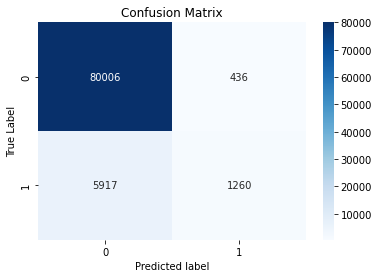

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     80442
         1.0       0.74      0.18      0.28      7177

    accuracy                           0.93     87619
   macro avg       0.84      0.59      0.62     87619
weighted avg       0.92      0.93      0.91     87619

ROC AUC Score: 0.59


In [15]:
# création de la matrice de confusion
plot_confusion_matrix(y_test, y_pred)

L'objectif du modèle est de minimiser les faux négatifs, c'est à dire le nombre de crédit prédit comme remboursés (prédiction classe 0) alors qu'ils ne le sont pas (classe réelle 1). Celà revient à maximiser le recall = (TP / (TP+FN)).

Ici le recall est très mauvais (recall=0.17 pour la classe 1). Du fait de la faible présence d'observation de la classe 1, le modèle va en majorité prévoir l'appartenance à la classe 0.

On voit que la ROC curve est également proche de 0.50 qui est le plus mauvais score.

## Régression logistique avec rééquilibrage des classes

L'idée est de tester la performance de différentes méthodes de rebalancing en utilisant la librairie imblearn:  
- RandomUnderSampler  
- RandomOverSampler  
- SMOTE  

### Undersampling

In [16]:
# define model
# define pipeline steps
steps = [('ros', RandomUnderSampler(random_state=42)), 
         ('scaler', MinMaxScaler()),
         ('model', LogisticRegression(penalty='none',
                                      solver='newton-cg'))]
# imblearn pipeline
pipeline2 = Pipeline(steps)

In [17]:
%%time
# Entrainement du modèle sur le train set
pipeline2.fit(X_train, y_train)
# Prévision sur le test set
y_pred = pipeline2.predict(X_test)

CPU times: user 606 ms, sys: 697 ms, total: 1.3 s
Wall time: 147 ms


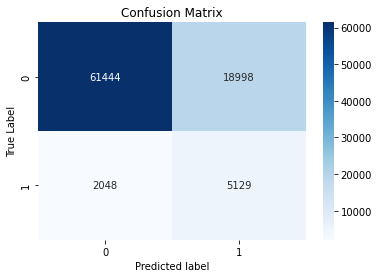

              precision    recall  f1-score   support

         0.0       0.97      0.76      0.85     80442
         1.0       0.21      0.71      0.33      7177

    accuracy                           0.76     87619
   macro avg       0.59      0.74      0.59     87619
weighted avg       0.91      0.76      0.81     87619

ROC AUC Score: 0.74


In [18]:
# création de la matrice de confusion
plot_confusion_matrix(y_test, y_pred)

On voit une nette ammélioration de la performance du modèle pour prévoir la classe 1 (recall, F1). Le score ROC AUC progresse également.

### Oversampling

In [19]:
# define model
# define pipeline steps
steps = [('ros', RandomOverSampler(random_state=42)), 
         ('scaler', MinMaxScaler()),
         ('model', LogisticRegression(penalty='none',
                                      solver='newton-cg'))]
# imblearn pipeline
pipeline3 = Pipeline(steps)

In [20]:
%%time
# Entrainement du modèle sur le train set
pipeline3.fit(X_train, y_train)
# Prévision sur le test set
y_pred = pipeline3.predict(X_test)

CPU times: user 19.7 s, sys: 13.6 s, total: 33.3 s
Wall time: 2.49 s


On voit que l'entrainement avec oversampling prend 10x plus de temps!

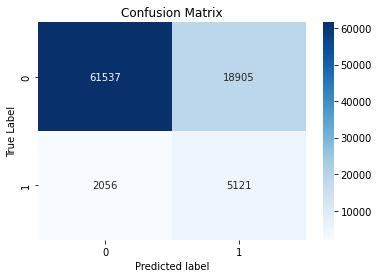

              precision    recall  f1-score   support

         0.0       0.97      0.76      0.85     80442
         1.0       0.21      0.71      0.33      7177

    accuracy                           0.76     87619
   macro avg       0.59      0.74      0.59     87619
weighted avg       0.91      0.76      0.81     87619

ROC AUC Score: 0.74


In [21]:
# création de la matrice de confusion
plot_confusion_matrix(y_test, y_pred)

L'oversampling montre des résultats légèrement supérieurs.

### SMOTE

On utilise un retraitement des classes avec la méthodologie SMOTE

In [22]:
# define model
# define pipeline steps
steps = [('smote', SMOTE(random_state=42)), 
         ('scaler', MinMaxScaler()),
         ('model', LogisticRegression(penalty='none',
                                      solver='newton-cg'))]
# imblearn pipeline
pipeline4 = Pipeline(steps)

In [23]:
%%time
# Entrainement du modèle sur le train set
pipeline4.fit(X_train, y_train)
# Prévision sur le test set
y_pred = pipeline4.predict(X_test)

CPU times: user 20.9 s, sys: 13.7 s, total: 34.7 s
Wall time: 2.62 s


Le SMOTE est encore plus long en termes d'exécution.

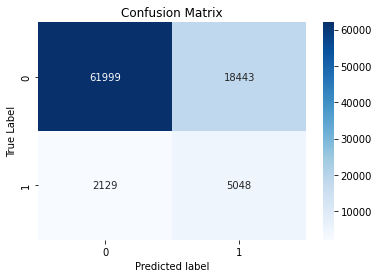

              precision    recall  f1-score   support

         0.0       0.97      0.77      0.86     80442
         1.0       0.21      0.70      0.33      7177

    accuracy                           0.77     87619
   macro avg       0.59      0.74      0.59     87619
weighted avg       0.91      0.77      0.81     87619

ROC AUC Score: 0.74


In [24]:
# création de la matrice de confusion
plot_confusion_matrix(y_test, y_pred)

Les 3 méthodes de rebalancing donnent des performances assez proches. A noter que SMOTE ne permet pas d'améliorer les performances. Au final, il est préférable d'utiliser du undersampling, ce qui permet de travailler sur des échantillons de taille plus restreinte donc d'avoir des temps de calcul plus courts.

## Régression logistique Lasso avec rééquilibrage des classes

On utilise de l'undersampling pour réduire les temps de calcul avec des performances équivalentes. Ici on ajoute une pénalisation des poids de type L1 (Lasso).

In [25]:
# define model
# define pipeline steps
steps = [('ros', RandomUnderSampler(random_state=42)), 
         ('scaler', MinMaxScaler()),
         ('model', LogisticRegression(penalty='l1',
                                      solver='liblinear',
                                      n_jobs=1))]
# imblearn pipeline
pipeline5 = Pipeline(steps)

In [26]:
%%time
# Entrainement du modèle sur le train set
pipeline5.fit(X_train, y_train)
# Prévision sur le test set
y_pred = pipeline5.predict(X_test)

CPU times: user 211 ms, sys: 2.95 ms, total: 214 ms
Wall time: 208 ms


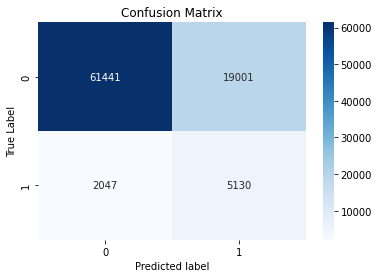

              precision    recall  f1-score   support

         0.0       0.97      0.76      0.85     80442
         1.0       0.21      0.71      0.33      7177

    accuracy                           0.76     87619
   macro avg       0.59      0.74      0.59     87619
weighted avg       0.91      0.76      0.81     87619

ROC AUC Score: 0.74


In [27]:
# création de la matrice de confusion
plot_confusion_matrix(y_test, y_pred)

Pas d'amélioration significative de la performance.

## Régression logistique Ridge avec rééquilibrage

C'est la régresssion logistique par défaut dans la fonction LogisticRegression de scikit-learn

In [28]:
# define model
# define pipeline steps
steps = [('ros', RandomUnderSampler(random_state=42)), 
         ('scaler', MinMaxScaler()),
         ('model', LogisticRegression(penalty='l2',
                                      solver='liblinear',
                                      ))]
# imblearn pipeline
pipeline6 = Pipeline(steps)

In [29]:
%%time
# Entrainement du modèle sur le train set
pipeline6.fit(X_train, y_train)
# Prévision sur le test set
y_pred = pipeline6.predict(X_test)

CPU times: user 152 ms, sys: 3.75 ms, total: 156 ms
Wall time: 151 ms


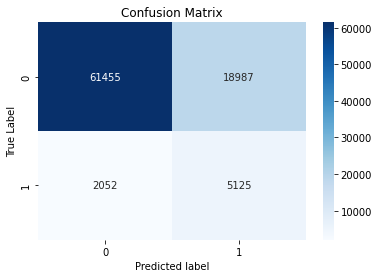

              precision    recall  f1-score   support

         0.0       0.97      0.76      0.85     80442
         1.0       0.21      0.71      0.33      7177

    accuracy                           0.76     87619
   macro avg       0.59      0.74      0.59     87619
weighted avg       0.91      0.76      0.81     87619

ROC AUC Score: 0.74


In [30]:
# création de la matrice de confusion
plot_confusion_matrix(y_test, y_pred)

### utilisation de l'option class_weight

In [31]:
# define model
# define pipeline steps
steps = [('ros', RandomUnderSampler(random_state=42)), 
         ('scaler', MinMaxScaler()),
         ('model', LogisticRegression(solver='liblinear',
                                      class_weight='balanced'))]
# imblearn pipeline
pipeline7 = Pipeline(steps)

In [32]:
%%time
# Entrainement du modèle sur le train set
pipeline7.fit(X_train, y_train)
# Prévision sur le test set
y_pred = pipeline7.predict(X_test)

CPU times: user 167 ms, sys: 6.38 ms, total: 174 ms
Wall time: 159 ms


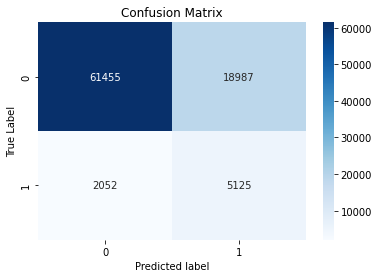

              precision    recall  f1-score   support

         0.0       0.97      0.76      0.85     80442
         1.0       0.21      0.71      0.33      7177

    accuracy                           0.76     87619
   macro avg       0.59      0.74      0.59     87619
weighted avg       0.91      0.76      0.81     87619

ROC AUC Score: 0.74


In [33]:
# création de la matrice de confusion
plot_confusion_matrix(y_test, y_pred)

### option RidgeClassifier()

Fonction alternative de scikit-learn

In [34]:
# define model
# define pipeline steps
steps = [('ros', RandomUnderSampler(random_state=42)), 
         ('scaler', MinMaxScaler()),
         ('model', RidgeClassifier())]
# imblearn pipeline
pipeline8 = Pipeline(steps)

In [35]:
%%time
# Entrainement du modèle sur le train set
pipeline8.fit(X_train, y_train)
# Prévision sur le test set
y_pred = pipeline8.predict(X_test)

CPU times: user 110 ms, sys: 127 ms, total: 237 ms
Wall time: 93.9 ms


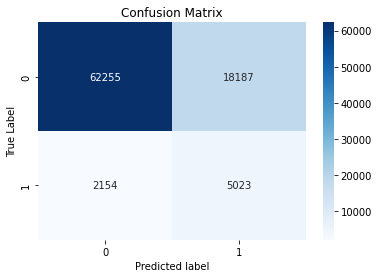

              precision    recall  f1-score   support

         0.0       0.97      0.77      0.86     80442
         1.0       0.22      0.70      0.33      7177

    accuracy                           0.77     87619
   macro avg       0.59      0.74      0.60     87619
weighted avg       0.91      0.77      0.82     87619

ROC AUC Score: 0.74


In [36]:
# création de la matrice de confusion
plot_confusion_matrix(y_test, y_pred)

## Régression logistique Elasticnet avec rééquilibrage des classes

In [37]:
# define model
# define pipeline steps
steps = [('ros', RandomUnderSampler(random_state=42)), 
         ('scaler', MinMaxScaler()),
         ('model', LogisticRegression(penalty='elasticnet',
                                      solver='saga',
                                      l1_ratio=0.5,
                                      n_jobs=-1))]
# imblearn pipeline
pipeline9 = Pipeline(steps)

In [38]:
%%time
# Entrainement du modèle sur le train set
pipeline9.fit(X_train, y_train)
# Prévision sur le test set
y_pred = pipeline9.predict(X_test)

CPU times: user 364 ms, sys: 6.86 ms, total: 370 ms
Wall time: 358 ms


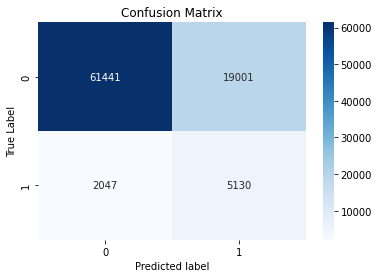

              precision    recall  f1-score   support

         0.0       0.97      0.76      0.85     80442
         1.0       0.21      0.71      0.33      7177

    accuracy                           0.76     87619
   macro avg       0.59      0.74      0.59     87619
weighted avg       0.91      0.76      0.81     87619

ROC AUC Score: 0.74


In [39]:
# création de la matrice de confusion
plot_confusion_matrix(y_test, y_pred)

# Optimisation des paramètres de régression logistique

Les différentes variantes testées ci-dessus ont des performances sensiblement égales. On va voir s'il est possible d'améliorer la performance via une optimisation des hyperparamètres avec une recherche sur grille.

In [40]:
# define model
# define pipeline steps
steps = [('ros', RandomUnderSampler(random_state=42)), 
         ('scaler', MinMaxScaler()),
         ('model', LogisticRegression())]
# imblearn pipeline
pipeline10 = Pipeline(steps)

In [41]:
# utilisation de folds
cv = StratifiedKFold(n_splits=3) 
# paramètres à tester
tuned_parameters = [{'scaler':[MinMaxScaler(), StandardScaler()],
                     'model__C': [0.001, 0.01, 0.1, 1],
                     'model__penalty': ['l2'],
                     'model__solver': ['liblinear', 'newton-cg']},
                    {'scaler':[MinMaxScaler(), StandardScaler()],
                     'model__C': [0.001, 0.01, 0.1, 1],
                     'model__penalty': ['l1'],
                     'model__solver': ['liblinear']},
                    {'scaler':[MinMaxScaler(), StandardScaler()],
                     'model__l1_ratio': [0.2, 0.5, 0.8],
                     'model__penalty': ['elasticnet'],
                     'model__solver': ['saga']}]
# optimisation du ROC AUC
print("# Tuning hyper-parameters for ROC AUC")
clf = GridSearchCV(pipeline10,
                   tuned_parameters,
                   scoring='roc_auc',
                   cv=cv,
                   n_jobs=-1)

# Tuning hyper-parameters for ROC AUC


In [42]:
%%time
clf.fit(X_train, y_train)

CPU times: user 1.68 s, sys: 1.52 s, total: 3.19 s
Wall time: 7.28 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('ros',
                                        RandomUnderSampler(random_state=42)),
                                       ('scaler', MinMaxScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'model__C': [0.001, 0.01, 0.1, 1],
                          'model__penalty': ['l2'],
                          'model__solver': ['liblinear', 'newton-cg'],
                          'scaler': [MinMaxScaler(), StandardScaler()]},
                         {'model__C': [0.001, 0.01, 0.1, 1],
                          'model__penalty': ['l1'],
                          'model__solver': ['liblinear'],
                          'scaler': [MinMaxScaler(), StandardScaler()]},
                         {'model__l1_ratio': [0.2, 0.5, 0.8],
                          'model__penalty': ['elasticnet'],
                          'model__solver': ['saga'],
                          'scaler': [MinMaxScaler(), StandardScaler()]}],
             scoring='roc_auc')

In [43]:
clf.best_params_

{'model__C': 0.01,
 'model__penalty': 'l2',
 'model__solver': 'newton-cg',
 'scaler': StandardScaler()}

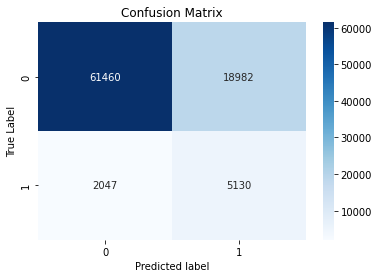

              precision    recall  f1-score   support

         0.0       0.97      0.76      0.85     80442
         1.0       0.21      0.71      0.33      7177

    accuracy                           0.76     87619
   macro avg       0.59      0.74      0.59     87619
weighted avg       0.91      0.76      0.81     87619

ROC AUC Score: 0.74


In [44]:
y_pred2 = clf.predict(X_test)
plot_confusion_matrix(y_test, y_pred2)

In [45]:
cv = StratifiedKFold(n_splits=3) 

tuned_parameters = [{'model__C': [0.005, 0.01, 0.05, 0.1],
                     'model__penalty': ['l2'],
                     'model__solver': ['newton-cg'],
                     'scaler': [StandardScaler()]}]

print("# Tuning hyper-parameters for recall")
clf = GridSearchCV(pipeline10,
                   tuned_parameters,
                   scoring='recall',
                   cv=cv,
                   n_jobs=-1)

# Tuning hyper-parameters for recall


In [46]:
%%time
clf.fit(X_train, y_train)

CPU times: user 637 ms, sys: 1.05 s, total: 1.69 s
Wall time: 1.33 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('ros',
                                        RandomUnderSampler(random_state=42)),
                                       ('scaler', MinMaxScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'model__C': [0.005, 0.01, 0.05, 0.1],
                          'model__penalty': ['l2'],
                          'model__solver': ['newton-cg'],
                          'scaler': [StandardScaler()]}],
             scoring='recall')

In [47]:
clf.best_params_

{'model__C': 0.05,
 'model__penalty': 'l2',
 'model__solver': 'newton-cg',
 'scaler': StandardScaler()}

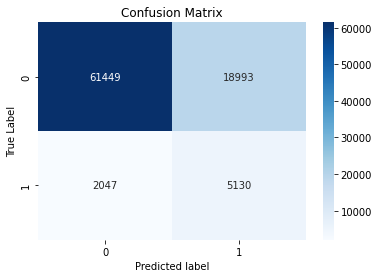

              precision    recall  f1-score   support

         0.0       0.97      0.76      0.85     80442
         1.0       0.21      0.71      0.33      7177

    accuracy                           0.76     87619
   macro avg       0.59      0.74      0.59     87619
weighted avg       0.91      0.76      0.81     87619

ROC AUC Score: 0.74


In [48]:
y_pred2 = clf.predict(X_test)
plot_confusion_matrix(y_test, y_pred2)

# Optimisation du threshold sur le modèle final

In [49]:
# define model
# define pipeline steps
steps = [('ros', RandomUnderSampler(random_state=42)), 
         ('scaler', StandardScaler()),
         ('model', LogisticRegression(C=0.01,
                                      penalty='l2',
                                      solver='newton-cg'))]
# imblearn pipeline
best_model = Pipeline(steps)

In [50]:
best_model.fit(X_train, y_train)

Pipeline(steps=[('ros', RandomUnderSampler(random_state=42)),
                ('scaler', StandardScaler()),
                ('model', LogisticRegression(C=0.01, solver='newton-cg'))])

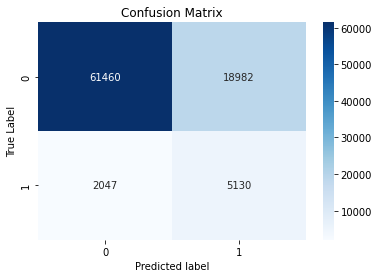

              precision    recall  f1-score   support

         0.0       0.97      0.76      0.85     80442
         1.0       0.21      0.71      0.33      7177

    accuracy                           0.76     87619
   macro avg       0.59      0.74      0.59     87619
weighted avg       0.91      0.76      0.81     87619

ROC AUC Score: 0.74


In [51]:
# prévision standard avec seuil à 0.5
y_pred = best_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)

On peut changer le seuil afin d'optimiser le modèle. Dans ce cas il faut utiliser la fonction 'predict_proba' et utiliser la probilité calculée sur la classe 1 donc  model.predict_proba(X_test)[:, 1]. Si cette probabilité est supérieure au seuil alors la prédiction est classe 1, autrement classe 0. Par défaut le seuil utilisé est 0.5 mais il est possible de le changer.

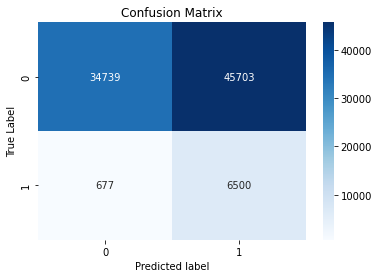

              precision    recall  f1-score   support

         0.0       0.98      0.43      0.60     80442
         1.0       0.12      0.91      0.22      7177

    accuracy                           0.47     87619
   macro avg       0.55      0.67      0.41     87619
weighted avg       0.91      0.47      0.57     87619

ROC AUC Score: 0.67


In [52]:
# Utilisation d'un seuil à 0.25 au lieu de 0.5.
threshold = 0.25
# Si le seuil est supérieur à 0.25, alors on considère que le crédit appartient à la classe 1
y_pred2 = (best_model.predict_proba(X_test)[:, 1] > threshold).astype('float')
plot_confusion_matrix(y_test, y_pred2)

On voit que baisser la seuil permet d'améliorer le recall. Par contre celà augmente le nombre de crédits refusés alors qu'ils devraient être acceptés. Il convient donc de trouver l'équilibre entre le taux de vrais positifs et de faux positifs. Cela revient à maximiser le AUC ROC.

https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

In [53]:
# Calcul des probabilités d'appartenir à la classe 1
y_scores = best_model.predict_proba(X_test)[:, 1]

0.8154886688693014


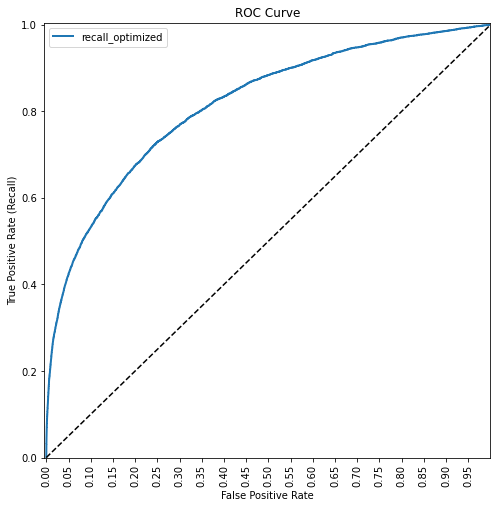

In [54]:
# Courbe ROC associée au modèle de régression logistique
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

In [55]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (auc_thresholds[ix], gmeans[ix]))

Best Threshold=0.484422, G-Mean=0.740


Le seuil optimal est de 48.744%.

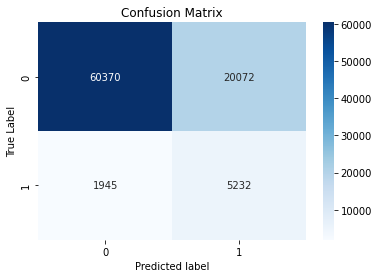

              precision    recall  f1-score   support

         0.0       0.97      0.75      0.85     80442
         1.0       0.21      0.73      0.32      7177

    accuracy                           0.75     87619
   macro avg       0.59      0.74      0.58     87619
weighted avg       0.91      0.75      0.80     87619

ROC AUC Score: 0.74


In [59]:
threshold = 0.484422
y_pred2 = (best_model.predict_proba(X_test)[:, 1] > threshold).astype('float')
plot_confusion_matrix(y_test, y_pred2)

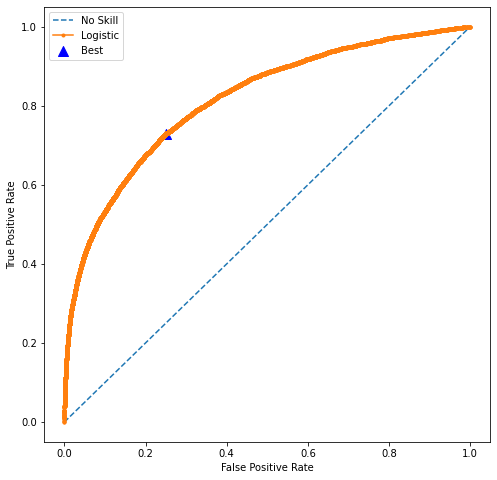

In [57]:
# plot the roc curve for the model
plt.figure(figsize=(8,8))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='^', color='blue', label='Best', s=100)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [58]:
### Create a Pickle file using serialization 
pickle_out = open("classifier_lr_final.pkl", "wb")
pickle.dump(best_model, pickle_out)
pickle_out.close()